# 1. Preparando ambiente

## Colocando pasta dos dados como Raiz

In [ ]:
from pyspark.sql import SparkSession

# Cria uma SparkSession
spark = (SparkSession.builder
         .appName("MinhaAppSpark")
         .master("local[*]")  # "local[*]" usa todos os núcleos disponíveis localmente
         .getOrCreate()
         )

# Verifique se a sessão foi criada
print(spark.version)

3.4.3


# Variáveis

In [ ]:
import sys
import os

# Adiciona o diretório atual ao Python path
sys.path.append(os.path.dirname(os.getcwd()))

from libs.mgi_libs.azure.storage import Storage

storage_log = Storage("files/sipe-u-log-hist-ate-2025")
storage_pefil = Storage("files/perfil")
storage_servidor = Storage("files/siape-servidor")

limit = 10000
random_seed = 42
storage_log

Storage(account_name='', container_name='', directory_name='files/sipe-u-log-hist-ate-2025', directory_path='/home/lima/projetos/mgi/azure/', local='local')

# 2. Pré-Processamento

## Escolhendo os CPF

- len(co_nivel_funcao ) = 3
- de 1.01 ate 1.07 - chere
- de 1.08 ate 1.10 - coordenador
- de 1.11 ate 1.13 - coordenador geral
- acima de 1.13 - diretor

In [ ]:
from pyspark.sql.functions import col, when, length, row_number, count, desc
from pyspark.sql.window import Window

# Carregar os dados da pasta usando o Spark
df_cpfs = (
    spark.read.parquet(storage_servidor.get_directory_name())
    .where(length(col("co_nivel_funcao")) == 3)  # Check length of co_nivel_funcao
    .withColumn(
        "classificacao",
        when(col("co_nivel_funcao").between(101, 107), "Chefe")
        .when(col("co_nivel_funcao").between(108, 110), "Coordenador")
        .when(col("co_nivel_funcao").between(111, 113), "Coordenador Geral")
        .otherwise("Diretor")
    )
    .where("da_obito = 0")
    .where("co_situacao_servidor = 1")
    .where("da_ocor_inatividade_serv = 0")
    .orderBy(desc("da_ocor_ingr_orgao_serv"))
)
# Agrupando por classificação e amostrando 100 registros por grupo
windowSpec = Window.partitionBy("classificacao").orderBy("co_nivel_funcao")  # Order by co_nivel_funcao
df_amostra = df_cpfs.withColumn("row_number", row_number().over(windowSpec)) \
                   .filter(col("row_number") <= 130) \
                   .drop("row_number")  # Remove the auxiliary column

# removendo quem tece mais de 2 papeis
windowSpec = Window.partitionBy("nu_cpf")
df_cpfs_count = df_amostra.withColumn("count", count("*").over(windowSpec))
df_amostra = df_cpfs_count.where(col("count") == 1).drop("count")

df_amostra.show()

+-------+------------+-----------------------------+-------------------+------------------------+----------------------+----------------+---------+---------------+----------------------+----------------------+-------------------------+------------------------+-----------------------+-------------------+--------+---------------------+---------------+--------------------+----------------+-------------------+------------------+-----------------+---------------+---------------------+---------+-------------+-------+--------------------+------------+-----------+---------------+----------------------+-------+-----------------------+------------------+-----------------------+-------------+--------+---------------------+------------------------+-----------------------+----------------------+-------------------+---------------+--------------------+------------------+-----------------------+-----------------------+-------------------+---------------+--------------------+--------------+------+----

In [ ]:
df_cpfs = df_amostra.groupBy(["nu_cpf", "classificacao"]).count().orderBy("count", ascending=False).drop("count")

df_cpfs.groupBy(["classificacao"]).count().orderBy("count", ascending=False).show()
df_cpfs.show()

+-----------------+-----+
|    classificacao|count|
+-----------------+-----+
|            Chefe|  130|
|          Diretor|  128|
|Coordenador Geral|  106|
|      Coordenador|   82|
+-----------------+-----+



+---------+-----------------+
|   nu_cpf|    classificacao|
+---------+-----------------+
| 55742424|          Diretor|
| 60412054|            Chefe|
|114314586|          Diretor|
|130988103|Coordenador Geral|
|171455894|            Chefe|
|281281173|Coordenador Geral|
|343194171|            Chefe|
|344040747|Coordenador Geral|
|599922982|Coordenador Geral|
|665956142|Coordenador Geral|
|670282847|            Chefe|
|690608519|          Diretor|
|747679410|Coordenador Geral|
|753183420|      Coordenador|
|811916006|            Chefe|
|824031636|            Chefe|
|839577400|Coordenador Geral|
|847524752|          Diretor|
|859054373|Coordenador Geral|
|865777942|            Chefe|
+---------+-----------------+
only showing top 20 rows



### Carregando dados

In [ ]:
from pyspark.sql.functions import trim, col

cpf_list = [row.nu_cpf for row in df_cpfs.select('nu_cpf').collect()]


# Carregar os dados da pasta usando o Spark
df = (
    spark.read.parquet(storage_log.get_directory_name())
    .withColumn('ch_arvore_senha_log', trim(col('ch_arvore_senha_log')))
    .where("ch_arvore_senha_log <> 'SIAPE' or trim(ch_arvore_senha_log) <> ''")
    .where("nu_cpf_usuario_log <> '11111111111'")
    .where(col('nu_cpf_usuario_log').isin(cpf_list))  # Aqui aplicamos o filtro correto
    .join(df_cpfs.select('nu_cpf', 'classificacao'),
          col('nu_cpf_usuario_log') == col('nu_cpf'),
          'left')  # Usar left join para garantir que todos os registros do df original estejam presentes
    .limit(limit)
)

# Mostrar algumas informações sobre o DataFrame
df.printSchema()

root
 |-- isn: long (nullable = true)
 |-- co_orgao_log: long (nullable = true)
 |-- ch_arvore_senha_log: string (nullable = true)
 |-- da_atualizacao_log: string (nullable = true)
 |-- ho_atualizacao_log: long (nullable = true)
 |-- nu_cpf_usuario_log: long (nullable = true)
 |-- co_terminal_log: string (nullable = true)
 |-- co_crh_log: long (nullable = true)
 |-- tx_dados_atualizados_log: string (nullable = true)
 |-- da_ano_mes_pagamento: integer (nullable = true)
 |-- tx_parametros_transacao: string (nullable = true)
 |-- nu_iden_unica_siape_log: integer (nullable = true)
 |-- matricula_inst_legal: long (nullable = true)
 |-- tx_dados_atualizados_log_2: string (nullable = true)
 |-- co_orgao_servidor: integer (nullable = true)
 |-- nu_cpf: long (nullable = true)
 |-- classificacao: string (nullable = true)



## Transformação 1

Alterar a coluna 'ch_arvore_senha_log' em 5 novas colunas.

Regra da expressão recular:
1. SIGLA do Sistema
1. [SUBSISTEMA]
1. [MODULO]
1. [OPCAO]
1. [ATIVIDADE]
1.  TRANSACAO

In [ ]:
# prompt: Transformar a coluna ch_arvore_senha_log em 6 colunas com a regra:
# Regra da expressão recular:
# - SIGLA_SISTEMA
# - [SUBSISTEMA]
# - [MODULO]
# - [OPCAO]
# - [ATIVIDADE]
# - TRANSACAO

from pyspark.sql.functions import regexp_extract

# Definir a expressão regular para extrair as informações da coluna 'ch_arvore_senha_log'
regex = r"^(\w+)(?:\s+(\w+))?(?:\s+(\w+))?(?:\s+(\w+))?(?:\s+(\w+))?\s+(\w+)$"

# Criar novas colunas usando regexp_extract
df = df.withColumn("SIGLA_SISTEMA", regexp_extract("ch_arvore_senha_log", regex, 1)) \
    .withColumn("SUBSISTEMA", regexp_extract("ch_arvore_senha_log", regex, 2)) \
    .withColumn("MODULO", regexp_extract("ch_arvore_senha_log", regex, 3)) \
    .withColumn("OPCAO", regexp_extract("ch_arvore_senha_log", regex, 4)) \
    .withColumn("ATIVIDADE", regexp_extract("ch_arvore_senha_log", regex, 5)) \
    .withColumn("TRANSACAO", regexp_extract("ch_arvore_senha_log", regex, 6))

# Remover colunas que não tem sistema [não deveria ter nenhuma]
df = df.dropna(how='any', subset=['SIGLA_SISTEMA', 'TRANSACAO'])

In [ ]:
# remover colunas: tx_dados_atualizados_log|tx_parametros_transacao
# muita informação pessoal
df = df.drop("tx_dados_atualizados_log", "tx_dados_atualizados_log_2", "tx_parametros_transacao")

In [ ]:
from pyspark.sql.functions import countDistinct

# Assuming 'df' is your PySpark DataFrame

# Get a list of all columns in the DataFrame
all_columns = df.columns

# Create a dictionary to store the unique counts for each column
unique_counts = {}

# Iterate through each column and calculate the number of unique values
for column in all_columns:
    unique_counts[column] = df.select(countDistinct(column)).first()[0]

# Print the unique counts for each column
for column, count in unique_counts.items():
    print(f"Column '{column}': {count} unique values")

Column 'isn': 10000 unique values
Column 'co_orgao_log': 43 unique values
Column 'ch_arvore_senha_log': 103 unique values
Column 'da_atualizacao_log': 86 unique values
Column 'ho_atualizacao_log': 5611 unique values
Column 'nu_cpf_usuario_log': 205 unique values
Column 'co_terminal_log': 119 unique values
Column 'co_crh_log': 1620 unique values
Column 'da_ano_mes_pagamento': 9 unique values
Column 'nu_iden_unica_siape_log': 1737 unique values
Column 'matricula_inst_legal': 19 unique values
Column 'co_orgao_servidor': 42 unique values
Column 'nu_cpf': 205 unique values
Column 'classificacao': 4 unique values
Column 'SIGLA_SISTEMA': 5 unique values
Column 'SUBSISTEMA': 14 unique values
Column 'MODULO': 22 unique values
Column 'OPCAO': 15 unique values
Column 'ATIVIDADE': 9 unique values
Column 'TRANSACAO': 92 unique values


## Transformaçao 2 - Anonimização

Trocar os nomes dos orgão e os cpf por uma sequencia numérica

In [ ]:
# prompt: como anonimizar dados de uma coluna? tenho algumas colunas para serem anonimizadas: co_orgao_log, matricula_inst_legal, co_orgao_servidor, nu_iden_unica_siape_log.
# Gostaria que fosse guardada a transformação para poder fazer a inversa.  Os valores que se repetirem precisam ter os mesmos indices
# 123 > 1
# 124 > 2
# 123 > 1

from pyspark.sql.functions import monotonically_increasing_id

# Lista de colunas a serem anonimizadas
colunas_anonimizar = [
    'co_orgao_log',
    'matricula_inst_legal',
    'co_orgao_servidor',
    'nu_cpf_usuario_log',
    'nu_iden_unica_siape_log',
    # 'ch_arvore_senha_log'
]
# colunas_anonimizar = []

# Criar um dicionário para armazenar a transformação de cada coluna
mapeamento_colunas = {}


def create_mapped(df, colunas_anonimizar):
    for coluna in colunas_anonimizar:
        # Criar um novo DataFrame com uma coluna de ID única para cada valor da coluna a ser anonimizada
        df_temp = df.select(coluna).distinct().withColumn("novo_valor", monotonically_increasing_id() + 1)

        # Salvar esse mapeamento em arquivo
        df_temp.write.mode("overwrite").parquet(storage_pefil.get_path(f"mapeamento_{coluna}"))
        print(df_temp.show(5))

        df = do_mapped(df, colunas_anonimizar, coluna, df_temp)
    return df


def load_mappped(df, colunas_anonimizar):
    for coluna in colunas_anonimizar:
        # Criar um novo DataFrame com uma coluna de ID única para cada valor da coluna a ser anonimizada
        df_temp = spark.read.parquet(storage_pefil.get_path(f"mapeamento_{coluna}", True))

        df = do_mapped(df, colunas_anonimizar, coluna, df_temp)
    return df


def do_mapped(df, colunas_anonimizar, coluna, df_temp):
    global mapeamento_colunas
    # Criar um dicionário com o mapeamento entre o valor original e o novo valor
    mapeamento_colunas[coluna] = df_temp.rdd.map(lambda row: (row[coluna], row["novo_valor"])).collectAsMap()
    # Substituir os valores da coluna original pelos novos valores usando o mapeamento
    df = df.replace(mapeamento_colunas[coluna], subset=[coluna])
    return df

print(colunas_anonimizar)
df = create_mapped(df, colunas_anonimizar)
# load_mappped(colunas_anonimizar)
# df.head(3)

['co_orgao_log', 'matricula_inst_legal', 'co_orgao_servidor', 'nu_cpf_usuario_log', 'nu_iden_unica_siape_log']


+------------+----------+
|co_orgao_log|novo_valor|
+------------+----------+
|       25000|         1|
|       57202|         2|
|       33200|         3|
|       36205|         4|
|       26000|         5|
+------------+----------+
only showing top 5 rows

None


+--------------------+----------+
|matricula_inst_legal|novo_valor|
+--------------------+----------+
|                   0|         1|
|        213003363503|         2|
|        213003358813|         3|
|        213003358704|         4|
|        213003421798|         5|
+--------------------+----------+
only showing top 5 rows

None


+-----------------+----------+
|co_orgao_servidor|novo_valor|
+-----------------+----------+
|                0|         1|
|            57202|         2|
|            33200|         3|
|            36205|         4|
|            25000|         5|
+-----------------+----------+
only showing top 5 rows

None


+------------------+----------+
|nu_cpf_usuario_log|novo_valor|
+------------------+----------+
|       10503246760|         1|
|       76868958820|         2|
|        3083664680|         3|
|         281281173|         4|
|       93095465491|         5|
+------------------+----------+
only showing top 5 rows

None


+-----------------------+----------+
|nu_iden_unica_siape_log|novo_valor|
+-----------------------+----------+
|               15358178|         1|
|                      0|         2|
|               15635104|         3|
|               14537389|         4|
|               22713921|         5|
+-----------------------+----------+
only showing top 5 rows

None


# Salvando df selecionado

In [ ]:
storage_pefil.get_path(f"subdata")

'/home/lima/projetos/mgi/azure/files/perfil/subdata'

In [ ]:
df.write.mode("overwrite").parquet(storage_pefil.get_path(f"subdata"))

24/10/24 11:36:13 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 35, Column 16: Compiling "processNext()"
org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 35, Column 16: Compiling "processNext()"
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:402)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:236)
	at org.codehaus.janino.UnitCompiler$2.visitCompilationUnit(UnitCompiler.java:363)
	at org.codehaus.janino.UnitCompiler$2.visitCompilationUnit(UnitCompiler.java:361)
	at org.codehaus.janino.Java$CompilationUnit.accept(Java.java:371)
	at org.codehaus.janino.UnitCompiler.compileUnit(UnitCompiler.java:361)
	at org.codehaus.janino.SimpleCompiler.cook(SimpleCompiler.java:264)
	at org.codehaus.janino.ClassBodyE

# Carregar o df selecionado

In [ ]:
# from pyspark.sql import SparkSession

# # Create a SparkSession
# spark = SparkSession.builder.appName("MySparkApp").getOrCreate()


# import pandas as pd
# df_completo = spark.read.parquet("subdata2.zip")
# # df_completo = pd.read_parquet('subdata2')
# df_completo.head(3)

In [ ]:
import pandas as pd
df = pd.read_parquet('part-00000-7e6d1dbb-2303-417e-b6e2-5a6a32fe80d7-c000.snappy.parquet')
# df = pd.read_parquet('part-00000-db7c6da0-7df9-4072-a2f2-12bece7f84c7-c000.snappy.parquet')
df.head(3)

,isn,co_orgao_log,ch_arvore_senha_log,da_atualizacao_log,ho_atualizacao_log,nu_cpf_usuario_log,co_terminal_log,co_crh_log,da_ano_mes_pagamento,nu_iden_unica_siape_log,matricula_inst_legal,co_orgao_servidor,classificacao,SIGLA_SISTEMA,SUBSISTEMA,MODULO,OPCAO,ATIVIDADE,TRANSACAO
0,4250438,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO
1,4250439,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO
2,4250440,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO


In [ ]:
# Na base de dados contem cerca de 1300 linhas com a coluna chave correta, mas as individuais em branco
df \
 [
     (df['SIGLA_SISTEMA'].str.strip().eq('')) &
     (df['SUBSISTEMA'].str.strip().eq('')) &
     (df['MODULO'].str.strip().eq('')) &
     (df['OPCAO'].str.strip().eq('')) &
     (df['ATIVIDADE'].str.strip().eq('')) &
     (df['TRANSACAO'].str.strip().eq(''))
 ]

,isn,co_orgao_log,ch_arvore_senha_log,da_atualizacao_log,ho_atualizacao_log,nu_cpf_usuario_log,co_terminal_log,co_crh_log,da_ano_mes_pagamento,nu_iden_unica_siape_log,...,co_orgao_servidor,classificacao,SIGLA_SISTEMA,SUBSISTEMA,MODULO,OPCAO,ATIVIDADE,TRANSACAO,dia_semana_log,horario_dia_log


In [ ]:
# Nesse codigo fazemos a extracao do campo chave para as colunas individuais
# (apesar que no caderno não chegamos a utilizar as colunas individuais, ja fica completa para o futuro)

# colunas = ['SIGLA_SISTEMA', 'SUBSISTEMA', 'MODULO', 'OPCAO', 'ATIVIDADE', 'TRANSACAO']

lista_atributos_chave = []

for chave in df['ch_arvore_senha_log']:
    # print(chave)
    atributos_chave = []
    atributos_chave_linha = []
    colunas = ['SUBSISTEMA', 'MODULO', 'OPCAO', 'ATIVIDADE']

    for i in chave.split(' '):
        if i != '':
            atributos_chave.append(i.strip())

    # 'SIGLA_SISTEMA'
    atributos_chave_linha.append(atributos_chave.pop(0))

    # 'TRANSACAO'
    if len(atributos_chave) > 0:
        atributos_chave_linha.append(atributos_chave.pop(-1))
    else:
        atributos_chave_linha.append('')

    for i in range(len(colunas)):
        if len(atributos_chave) > 0:
            atributos_chave_linha.append(atributos_chave.pop(0))
        else:
            atributos_chave_linha.append('')

    lista_atributos_chave.append(atributos_chave_linha)

df[['SIGLA_SISTEMA', 'TRANSACAO', 'SUBSISTEMA', 'MODULO', 'OPCAO', 'ATIVIDADE']] = lista_atributos_chave

In [ ]:
lista_atributos_chave

In [ ]:
df.head(3)

,isn,co_orgao_log,ch_arvore_senha_log,da_atualizacao_log,ho_atualizacao_log,nu_cpf_usuario_log,co_terminal_log,co_crh_log,da_ano_mes_pagamento,nu_iden_unica_siape_log,matricula_inst_legal,co_orgao_servidor,classificacao,SIGLA_SISTEMA,SUBSISTEMA,MODULO,OPCAO,ATIVIDADE,TRANSACAO
0,4250438,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO
1,4250439,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO
2,4250440,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO


In [ ]:
# exemplo de registro corrigido
df.iloc[6]

,6
isn,4250444
co_orgao_log,13
ch_arvore_senha_log,SIAPE SIAPENET FERIASWEB INCLUSAO
da_atualizacao_log,2024-02-13
ho_atualizacao_log,84837
nu_cpf_usuario_log,18
co_terminal_log,NATUSER
co_crh_log,1389761
da_ano_mes_pagamento,202402
nu_iden_unica_siape_log,48


In [ ]:
df[['SIGLA_SISTEMA', 'SUBSISTEMA', 'MODULO', 'OPCAO', 'ATIVIDADE','TRANSACAO']][~(df['TRANSACAO'].str.strip().eq(''))].value_counts()

SIGLA_SISTEMA  SUBSISTEMA  MODULO     OPCAO      ATIVIDADE  TRANSACAO           
SIAPE          SIAPENET    FERIASWEB                        ALTERACAO               1753
                                                            INCLUSAO                1106
                           ORGAO                            LOGIN                    947
               FOLHA       ATUASERV                         FPATPEQMSE               940
               CADSIAPE    CADASTRO   ATUCADAST             CDALCONPGDN92116W4       717
                                                                                    ... 
               FOLHA                                        ATUASUPLINFPCLSUPLIN       1
               SIAPECAD    AUSENCIAS  FERIAS     INTERRFER  CACAINTFER                 1
                                      LPA                   CACSLPAHT                  1
                           PFU        EXERCICIO             CAEXEXRCER                 1
               SAUDE                                        ALTE-OCOR                  1
Name: count, Length: 102, dtype: int64

In [ ]:
# count lines for da_atualizacao_log and nu_cpf_usuario_log combination
df.groupby(['ch_arvore_senha_log', 'da_atualizacao_log', 'nu_cpf_usuario_log', 'co_terminal_log', 'co_orgao_servidor']).size().reset_index(name='count')

# ho_atualizacao_log

,ch_arvore_senha_log,da_atualizacao_log,nu_cpf_usuario_log,co_terminal_log,co_orgao_servidor,count
0,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-08,27,O92116YS,1,1
1,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-08,48,O92116YS,1,1
2,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-29,27,O92116YS,1,2
3,FOLHA FOLHA ATUASERV FPATMOVFIN,2024-01-03,26,AWV86833,13,8
4,FOLHA FOLHA ATUASERV FPATMOVFIN,2024-01-04,3,AWVABR6H,3,2
...,...,...,...,...,...,...
1914,SOUGOV SOUGOV AUX.TRANSP,2024-05-15,120,NATUSER,11,1
1915,SOUGOV SOUGOV AUX.TRANSP,2024-06-05,134,NATUSER,11,1
1916,SOUGOV SOUGOV AUX.TRANSP,2024-06-10,141,NATUSER,3,1
1917,SOUGOV SOUGOV AUX.TRANSP,2024-06-10,142,NATUSER,4,1


In [ ]:
df[['co_terminal_log']].value_counts().head(10)

,count
co_terminal_log,
NATUSER,3486
NDV,2985
AWVABR6H,1286
AWVAA00A,525
AWV29275,151
AWVAMARK,135
MOBILE,110
AWVAIV52,88
AWV86833,87


In [ ]:
df.describe()

,isn,co_orgao_log,ho_atualizacao_log,nu_cpf_usuario_log,co_crh_log,da_ano_mes_pagamento,nu_iden_unica_siape_log,matricula_inst_legal,co_orgao_servidor
count,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.130604e+07,7.408600,132885.317100,42.212200,9.010970e+05,202242.442900,612.941200,1.022900,5.833200
std,7.515966e+06,7.413619,33934.739215,47.318306,7.541221e+05,5722.856255,531.494341,0.541484,5.744186
min,1.249200e+04,1.000000,1134.000000,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000
25%,4.088932e+06,2.000000,103513.000000,4.000000,0.000000e+00,202402.000000,30.000000,1.000000,1.000000
50%,9.987112e+06,7.000000,134184.000000,27.000000,1.131699e+06,202404.000000,535.000000,1.000000,5.000000
75%,1.690060e+07,8.000000,161200.000000,52.000000,1.632319e+06,202406.000000,1056.000000,1.000000,8.000000
max,2.298794e+07,43.000000,234436.000000,205.000000,2.150880e+06,202408.000000,1737.000000,19.000000,42.000000


In [ ]:
df[['da_atualizacao_log', 'ho_atualizacao_log']].value_counts()

da_atualizacao_log  ho_atualizacao_log
2024-06-11          103513                294
2024-05-16          164026                141
2024-02-09          132412                 67
2024-04-01          151237                 55
2024-02-16          172012                 49
                                         ... 
2024-03-25          90958                   1
                    85730                   1
                    85439                   1
                    80950                   1
2024-05-08          155517                  1
Name: count, Length: 5818, dtype: int64

In [ ]:
df[['co_orgao_log', 'co_orgao_servidor', 'nu_cpf_usuario_log']].value_counts().head(10)

co_orgao_log  co_orgao_servidor  nu_cpf_usuario_log
1             5                  4                     1891
8             13                 50                     726
7             8                  12                     548
8             13                 27                     384
                                 30                     329
25            20                 107                    295
7             1                  19                     189
1             1                  4                      181
3             3                  16                     181
                                 9                      180
Name: count, dtype: int64

In [ ]:
df[['co_crh_log']].value_counts()

,count
co_crh_log,
0,3075
11270,90
1864690,76
1691385,53
1183657,48
...,...
1400783,1
1402689,1
1404482,1


In [ ]:
# df = spark.read.parquet(storage_pefil.get_path(f"subdata2"))
# df.printSchema()

## Transformação 3

Transformar o log normal em uma matrix incidência.

T = Transação [ch_arvore_senha_log]

A matriz a ser criada é TxT porém com os seguintes detalhes.
Agrupar por [CRITÉRIOS]

CRITÉRIOS:
1. Por órgão: co_orgao_log
2. Por órgão do servidor: co_orgao_servidor
3. Por ano ou mês ou dia: da_atualizacao_log

### Explicação do processo:

Para transformar em uma matrix incidência. Vamos rodar todas as transações que um CPF fez por dia.

Se o log regostrou A em um horário e depois B num horário subsequente no mesmo dia. Vamos crira um aresta, A -> B, com o valor 1, se voltar para A e de A for para B, então a aresta A->B agora vale 2. Se no dia subsequente ele saiu novamente de A -> B, então o valor passa a ser 3.

Lembrando que A -> B é diferente de B -> A. Ou seja, estamos criando um DAG, grafo direcionado.

Serão criados n grafos de acordo com os agrupadores: 'co_orgao_log', 'matricula_inst_legal', 'co_orgao_servidor', 'nu_cpf_usuario_log', 'nu_iden_unica_siape_log'

In [ ]:
def fill_graph(graph, origem, destino):
    if origem not in graph:
        graph[origem] = {}

    if destino not in graph[origem]:
        graph[origem][destino] = 1
    else:
        graph[origem][destino] += 1

In [ ]:
def generate_graph(df_main):
    index_cpf = 'nu_cpf_usuario_log'
    index_data = 'da_atualizacao_log'
    index_transacao = "TRANSACAO"

    tmp_graph = {}

    df_indice_cpf = df_main.groupBy(index_cpf).count().orderBy("count", ascending=False)
    # print("df_indice_cpf", df_indice_cpf.head(5))
    for row_cpf in df_indice_cpf.collect():
        # print(row_cpf)
        cpf = row_cpf[index_cpf]
        # print("cpf", cpf)
        df_tmp_cpf = df_main.filter(df_main[index_cpf] == cpf)
        # print("df_tmp_cpf", df_tmp_cpf.count())

        df_indice_data = df_tmp_cpf.groupBy(index_data).count().orderBy("count", ascending=False)
        # print("df_indice_data", df_indice_data.count())

        # Iterate over unique data of 'cpf','sistema'
        for row_data in df_indice_data.collect():  # Iterate over pandas DataFrame
            # print("data", row_data)
            data = row_data[index_data]
            df_tmp_acao = df_tmp_cpf.filter(df_tmp_cpf[index_data] == data)
            # print("df_tmp_acao", df_tmp_acao.count())

            if df_tmp_acao.count() < 2:
                continue
            count = 1
            # Iterate over unique 'acao' of 'data','cpf','sistema'
            for row_acao in df_tmp_acao.collect():  # Iterate over pandas DataFrame
                # progress.next()
                destino = row_acao[index_transacao]
                if destino in [
                    'SIAPE     SIAPENET  ORGAO               LOGIN',
                    'SIAPE',
                    '',
                    'LOGIN'
                ]:
                    continue
                # Dividir o texto em uma lista de palavras
                # origem = re.findall(pattern, origem)
                if count > 1:
                    # palavras = [destino[i:i+10] for i in range(0, len(destino), 10)]
                    # destino = palavras[-1]
                    fill_graph(tmp_graph, origem, destino)

                origem = destino

                count += 1

    return tmp_graph

In [ ]:
def generate_graph_by(df, index, index_name):
    graph = {}
    df_index = df.groupBy(index).count().orderBy("count", ascending=False)
    print(index_name, df_index.count())

    for row_sistema in df_index.collect():
        # print(row_sistema)
        camada = row_sistema[index]
        # print("sistema", sistema)
        df_tmp_main = df.filter(df[index] == camada)
        # print("df_tmp_sistema", df_tmp_sistema.count())

        # Iterate over unique 'cpf' of 'sistema'
        graph[f"{index_name}_{camada}"] = generate_graph(df_tmp_main)

    # loberar memoria do df_tmp_main
    df_tmp_main.unpersist()
    df_index.unpersist()
    return graph

## Gerando o grafo filtrado por Sistema

In [ ]:
# Inicializando o grafo
graph = {}

# Sistema
index = 'SIGLA_SISTEMA'
index_name = 'sistema'
graph.update(generate_graph_by(df, index, index_name))

# Órgão
index = 'co_orgao_log'
index_name = 'orgao'
graph.update(generate_graph_by(df, index, index_name))

## Salvando o grafo em um arquivo

In [ ]:
import json
graph_file = storage_pefil.get_path("graph.json")
# Abrindo um arquivo para escrita
with open(graph_file, 'w') as arquivo:
    json.dump(graph, arquivo, indent=4)

## Carregando o grafo

In [ ]:
import json
graph_file = storage_pefil.get_path("graph.json")

with open(graph_file, 'r') as arquivo:
    graph = json.load(arquivo)

print(graph)

{'SIAPE': {'AFASTAMENT': {'AFASTAMENT': 582, 'AFAST': 68, 'CACAFERIAS': 1, 'DEPENDENTECDIADEPEND': 1}, 'AFAST': {'AFASTAMENT': 54, 'AFAST': 34}, 'CDALFUNCB': {'CDALFUNCB': 335, 'CDATDADBAN': 3}, 'ADICIONAISCONCESSAO': {'ADICIONAISCONCESSAO': 530}, 'CONCURSADOEDITALHOMOCAINCONCUR': {'DPFINAL': 2}, 'DPFINAL': {'CAINCONPOR': 2, 'CAIFPUBLIC': 2, 'DPFINAL': 1, 'CACAFERIAS': 1, 'PROVIMENTOCAPVSEMVA': 2, 'DEPENDENTECDIADEPEND': 1, 'PEATPROVEX': 1, 'CAINMATRIC': 1}, 'CAINCONPOR': {'CAINCONPOR': 2, 'DPFINAL': 2}, 'CAIFPUBLIC': {'CAATPOSSE': 2}, 'CAATPOSSE': {'CAINMATRIC': 1, 'PROVIMENTOCAPVPCAPOS': 1}, 'CAINMATRIC': {'CAEXMATRIC': 1, 'DPEDITADL': 2, 'PEATPROVEX': 2}, 'CAEXMATRIC': {'PROVIMENTOCAPVPCAPOS': 1}, 'PROVIMENTOCAPVPCAPOS': {'PROVIMENTOCAPVPCAPOS': 4, 'CAATDADSIA': 2, 'CALCEXERIN': 1}, 'CAATDADSIA': {'CALCEXERIN': 2, 'CDCNPJEST': 5, 'CAATDADSIA': 2, 'DEPENDENTECDIADEPEND': 1, 'ALTDADOPCACAALDTPCA': 1, 'CDALFUNC': 1, 'CANOPFUDEX': 1}, 'CALCEXERIN': {'CALCEXERIN': 6, 'CONCURSADOEDITALHOM

## Desenhando o grafo no formato dot e salvando em um arquivo pdf


In [ ]:
import graphviz


for camada in graph:
    dot = graphviz.Graph(comment='Autorizações')
    for origem in graph[camada]:
        # label = origem[:-20]
        dot.node(origem, label=origem)
        for destino in graph[camada][origem]:
            dot.node(destino, label=destino)
            dot.edge(origem, destino, label="%d" % graph[camada][origem][destino])
    dot.render(f'autoriza_{camada}.dot')  # Renderizar e abrir a imagem

# print(dot.source)  # Visualizar o código DOT


In [ ]:
import numpy as np

adjacence_matrix = {}
dicionario = {}
collums = set()
for camada in graph:
    for origem in graph[camada]:
        for destino in graph[camada][origem]:
            collums.add(origem)
            collums.add(destino)
    if camada not in adjacence_matrix:
        adjacence_matrix[camada] = {}

    adjacence_matrix[camada] = np.zeros((len(collums), len(collums)))
    dicionario[camada] = dict(zip(collums, range(len(collums))))
    # print(dicionario[sistema])

for camada in graph:
    d = dicionario[camada]
    for origem in graph[camada]:
        for destino in graph[camada][origem]:
            adjacence_matrix[camada][d[origem]][d[destino]] = graph[camada][origem][destino]
adjacence_matrix

{'EXONERACAOCACAVACPFU': 0, 'FPATMOVRUB': 1, 'CDALFUNC': 2, 'CACAFERIAS': 3, 'CDISIMPREN': 4, 'ATUAPENSIOFPATPSCALC': 5, 'GRINBENEF': 6, 'CAALENDRH': 7, 'CAATCONBE': 8, 'DEPENDENTECDIADEPEND': 9, 'CAIFEXERC': 10, 'CDINREGISTO92116OE': 11, 'FORMACALC': 12, 'CDATOBITO': 13, 'PROVIMENTOCAPVPROMOC': 14, 'CACAINTFER': 15, 'INTEGRACAOCADTMATFP': 16, 'INTEGRACAOVINCULA': 17, 'PROVIMENTOCAPVPCAPOS': 18, 'CAATDADSIA': 19, 'AFASTAMENT': 20, 'CDATAPOSEN': 21, 'CAINMATRIC': 22, 'CDALFUNCB': 23, 'COMPATIB': 24, 'CAAPSERVID': 25, 'CAEXFERIAS': 26, 'CALCEXEXT': 27, 'CAIFPUBLIC': 28, 'GRPROCESSOGRDESBLQRH': 29, 'CAINPCAHIS': 30, 'CDEXCADASTO92116ZH': 31, 'CANOPFUDIR': 32, 'INTEGRACAOCARTMATFP': 33, 'COMPROREND': 34, 'PEATPROVEX': 35, 'CDATDADBAN': 36, 'CDALPSBENE': 37, 'CDINFORMRH': 38, 'CAAAFUNCAO': 39, 'CACODETPFU': 40, 'CANOPFUDEX': 41, 'CAEXLOCEXE': 42, 'DPEDITADL': 43, 'FPATRENDEX': 44, 'DADCADAST': 45, 'CDISPSSABP': 46, 'CAITFERIAS': 47, 'DPFINAL': 48, 'CDINREGIST': 49, 'CDATALIIND': 50, 'GRPROC

{'SIAPE': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 19.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., 80.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  2.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 16.]]),
 'FOLHA': array([[505.,   2.],
        [  0.,   0.]]),
 'SIAPENET': array([[66.,  0.],
        [ 0., 20.]]),
 'SIAPECAD': array([[26.,  0.],
        [ 0.,  2.]])}

SIAPE
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11
k 12
k 13
k 14
k 15


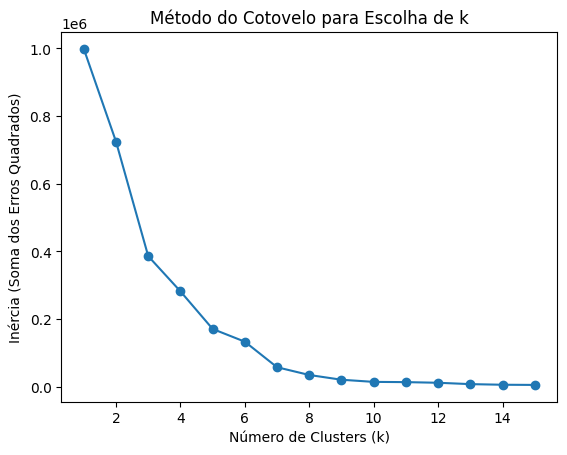

FOLHA
k 1


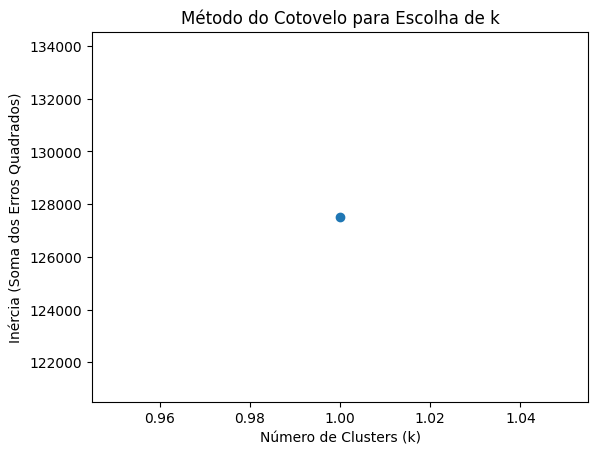

SIAPENET
k 1


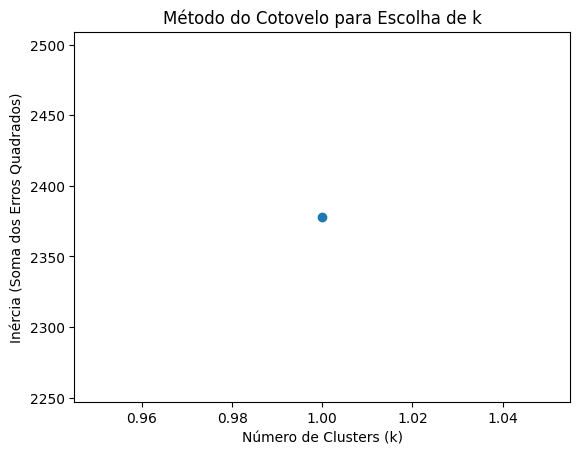

SIAPECAD
k 1


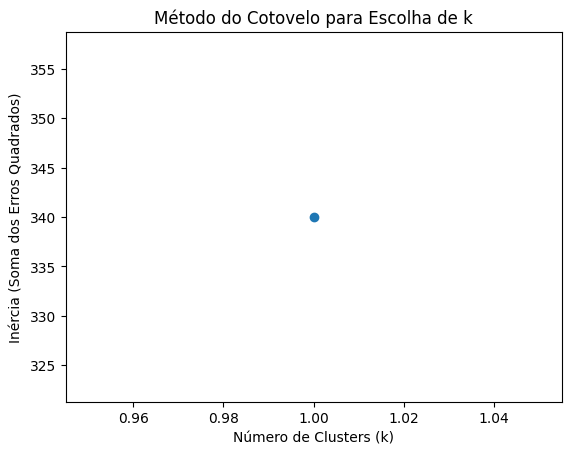

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans

for camada in adjacence_matrix:
    print(camada)
    # Gerar dados de exemplo
    X = adjacence_matrix[camada]
    k_values = range(1, int(1.5*math.sqrt(X.shape[1])))
    inercia = []
    for k in k_values:
        print("k", k)
        # Criar o modelo de clusterização K-Means
        kmeans = KMeans(n_clusters=k, random_state=random_seed)
        kmeans.fit(X)

        # Prever os clusters
        y_kmeans = kmeans.predict(X)
        print(y_kmeans)
        inercia.append(kmeans.inertia_)

    # Plotar a inércia para cada valor de k
    plt.plot(k_values, inercia, marker='o')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inércia (Soma dos Erros Quadrados)')
    plt.title('Método do Cotovelo para Escolha de k')
    plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Exemplo de uma matriz de incidência (5 objetos com 4 características)
matriz_incidencia = np.array([
    [1, 0, 0, 1],  # Objeto 1
    [1, 1, 0, 0],  # Objeto 2
    [0, 1, 1, 0],  # Objeto 3
    [1, 0, 0, 1],  # Objeto 4
    [0, 1, 1, 1],  # Objeto 5
])

# Número de clusters (definido pelo usuário)
num_clusters = 5

# Criar o modelo K-Means
kmeans = KMeans(n_clusters=num_clusters)

# Ajustar o modelo à matriz de incidência
kmeans.fit(matriz_incidencia)

# Prever os clusters
rótulos = kmeans.predict(matriz_incidencia)

# Exibir os rótulos dos clusters
print("Rótulos dos clusters:", rótulos)

# Exibir os centróides dos clusters
print("Centróides dos clusters:", kmeans.cluster_centers_)


# Seção com a parte final do caderno

In [ ]:
df.head(3)

,isn,co_orgao_log,ch_arvore_senha_log,da_atualizacao_log,ho_atualizacao_log,nu_cpf_usuario_log,co_terminal_log,co_crh_log,da_ano_mes_pagamento,nu_iden_unica_siape_log,matricula_inst_legal,co_orgao_servidor,classificacao,SIGLA_SISTEMA,SUBSISTEMA,MODULO,OPCAO,ATIVIDADE,TRANSACAO
0,4250438,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO
1,4250439,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO
2,4250440,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,1,1,Diretor,SIAPE,SIAPENET,FERIASWEB,,,INCLUSAO


In [ ]:
df.groupby(['ch_arvore_senha_log', 'da_atualizacao_log', 'nu_cpf_usuario_log', 'co_terminal_log', 'co_orgao_servidor', 'classificacao']).size().reset_index(name='count')

# ho_atualizacao_log

,ch_arvore_senha_log,da_atualizacao_log,nu_cpf_usuario_log,co_terminal_log,co_orgao_servidor,classificacao,count
0,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-08,27,O92116YS,1,Coordenador Geral,1
1,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-08,48,O92116YS,1,Coordenador,1
2,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-29,27,O92116YS,1,Coordenador Geral,2
3,FOLHA FOLHA ATUASERV FPATMOVFIN,2024-01-03,26,AWV86833,13,Coordenador,8
4,FOLHA FOLHA ATUASERV FPATMOVFIN,2024-01-04,3,AWVABR6H,3,Coordenador Geral,2
...,...,...,...,...,...,...,...
1914,SOUGOV SOUGOV AUX.TRANSP,2024-05-15,120,NATUSER,11,Diretor,1
1915,SOUGOV SOUGOV AUX.TRANSP,2024-06-05,134,NATUSER,11,Chefe,1
1916,SOUGOV SOUGOV AUX.TRANSP,2024-06-10,141,NATUSER,3,Diretor,1
1917,SOUGOV SOUGOV AUX.TRANSP,2024-06-10,142,NATUSER,4,Chefe,1


In [ ]:
df.groupby(['ch_arvore_senha_log', 'co_orgao_servidor', 'classificacao']).size().reset_index(name='count')

# ho_atualizacao_log

,ch_arvore_senha_log,co_orgao_servidor,classificacao,count
0,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,1,Coordenador,1
1,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,1,Coordenador Geral,3
2,FOLHA FOLHA ATUASERV FPATMOVFIN,3,Coordenador Geral,74
3,FOLHA FOLHA ATUASERV FPATMOVFIN,13,Coordenador,74
4,SENHA-REDEADMUSU HABUSU IALPAHUSU ALTERA,1,Coordenador Geral,11
...,...,...,...,...
324,SOUGOV SOUGOV AUX.TRANSP,10,Chefe,4
325,SOUGOV SOUGOV AUX.TRANSP,11,Chefe,2
326,SOUGOV SOUGOV AUX.TRANSP,11,Diretor,2
327,SOUGOV SOUGOV AUX.TRANSP,25,Chefe,1


In [ ]:
df.groupby(['ch_arvore_senha_log', 'classificacao']).size().reset_index(name='count')

# ho_atualizacao_log

,ch_arvore_senha_log,classificacao,count
0,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,Coordenador,1
1,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,Coordenador Geral,3
2,FOLHA FOLHA ATUASERV FPATMOVFIN,Coordenador,74
3,FOLHA FOLHA ATUASERV FPATMOVFIN,Coordenador Geral,74
4,SENHA-REDEADMUSU HABUSU IALPAHUSU ALTERA,Coordenador Geral,11
...,...,...,...
175,SOUGOV SOUGOV AUTOR.IRPF,Coordenador Geral,2
176,SOUGOV SOUGOV AUTOR.IRPF,Diretor,1
177,SOUGOV SOUGOV AUX.TRANSP,Chefe,13
178,SOUGOV SOUGOV AUX.TRANSP,Coordenador Geral,1


In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler  # Import OrdinalEncoder and StandardScaler
from sklearn.cluster import mean_shift

ordinal_encoder = OrdinalEncoder()

# Create a transformation pipeline
pipeline = Pipeline([
    ('ordinal_encoder', ordinal_encoder),
])

X_transformed = pipeline.fit_transform(df[['ch_arvore_senha_log', 'classificacao']])
X_transformed

array([[93.,  3.],
       [93.,  3.],
       [93.,  3.],
       ...,
       [ 5.,  2.],
       [ 5.,  2.],
       [ 5.,  2.]])

In [ ]:
# Import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics



# Define the scaler and apply to the data
# X = np.array(df).astype(np.float64)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_transformed)

# X_scaled = df.to_numpy()
# X_scaled = df[['ch_arvore_senha_log', 'classificacao']].to_numpy()
print(X_scaled)


[[0.88571429 1.        ]
 [0.88571429 1.        ]
 [0.88571429 1.        ]
 ...
 [0.04761905 0.66666667]
 [0.04761905 0.66666667]
 [0.04761905 0.66666667]]


In [ ]:
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

# # Run the kmeans model on scaled data
# kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)

# # Get the cluster number for each datapoint
# X_clusters = kmeans.predict(X_scaled)

# # Save the cluster centroids
# X_clusters_centers = kmeans.cluster_centers_

# # Calculate the distance to the cluster centroid for each point
# dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

# # Create predictions based on distance
# km_y_pred = np.array(dist)
# km_y_pred[dist>=np.percentile(dist, 93)] = 1
# km_y_pred[dist<np.percentile(dist, 93)] = 0

In [ ]:
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, roc_auc_score

# # Obtain the ROC score
# roc_auc_score(y_test, km_y_pred)


In [ ]:
# # Create a confusion matrix
# km_cm = confusion_matrix(y_test, km_y_pred)

# # Plot the confusion matrix in a figure to visualize results
# plot_confusion_matrix(km_cm)

In [ ]:
# # Split the data into training and test set
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# # Define K-means model
# kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# # Obtain predictions and calculate distance from cluster centroid
# X_test_clusters = kmeans.predict(X_test)
# X_test_clusters_centers = kmeans.cluster_centers_
# dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# # Create fraud predictions based on outliers on clusters
# km_y_pred = np.array(dist)
# km_y_pred[dist >= np.percentile(dist, 95)] = 1
# km_y_pred[dist < np.percentile(dist, 95)] = 0

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

# Experiment with different values for eps and min_samples
# Try smaller values for eps to create more clusters
# Try larger values for min_samples to require more points per cluster
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Example range
min_samples_values = [5, 10, 15, 20]  # Example range

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(X_scaled)
        pred_labels = db.labels_

        # Count the total number of clusters (excluding noise)
        n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

        # Check if there are at least 2 clusters before calculating silhouette score
        if n_clusters_ > 1:
            silhouette_score = metrics.silhouette_score(X_scaled, pred_labels)
            # homogeneity_score = metrics.homogeneity_score(labels, pred_labels)(X_scaled, pred_labels)
            # print(f'eps={eps}, min_samples={min_samples}: Estimated number of clusters: {n_clusters_}, Homogeneity: {homogeneity_score:0.3f}, Silhouette Coefficient: {silhouette_score:0.3f}')
            print(f'eps={eps}, min_samples={min_samples}: Estimated number of clusters: {n_clusters_}, Silhouette Coefficient: {silhouette_score:0.3f}')
        else:
            print(f'eps={eps}, min_samples={min_samples}: Only one cluster or all noise found.')

eps=0.1, min_samples=5: Estimated number of clusters: 8, Silhouette Coefficient: 0.320
eps=0.1, min_samples=10: Estimated number of clusters: 7, Silhouette Coefficient: 0.320
eps=0.1, min_samples=15: Estimated number of clusters: 6, Silhouette Coefficient: 0.328
eps=0.1, min_samples=20: Estimated number of clusters: 7, Silhouette Coefficient: 0.328
eps=0.2, min_samples=5: Estimated number of clusters: 5, Silhouette Coefficient: 0.319
eps=0.2, min_samples=10: Estimated number of clusters: 5, Silhouette Coefficient: 0.319
eps=0.2, min_samples=15: Estimated number of clusters: 5, Silhouette Coefficient: 0.319
eps=0.2, min_samples=20: Estimated number of clusters: 5, Silhouette Coefficient: 0.319
eps=0.3, min_samples=5: Estimated number of clusters: 5, Silhouette Coefficient: 0.319
eps=0.3, min_samples=10: Estimated number of clusters: 5, Silhouette Coefficient: 0.319
eps=0.3, min_samples=15: Estimated number of clusters: 5, Silhouette Coefficient: 0.319
eps=0.3, min_samples=20: Estimated 

KeyboardInterrupt: 

In [ ]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[10000]


In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.1, min_samples=20, n_jobs=-1).fit(X_scaled)

# Get the cluster labels (aka numbers)
pred_labels = db.labels_

# Count the total number of clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

# Print model results
print(f'Estimated number of clusters: {n_clusters_}')
# >>> Estimated number of clusters: 31

# Print model results
print(f'Silhouette Coefficient: {metrics.silhouette_score(X_scaled, pred_labels):0.3f}')
# >>> Silhouette Coefficient: 0.359

# Get sample counts in each cluster
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)

Estimated number of clusters: 7
Silhouette Coefficient: 0.328
[1309 1802 4663  628  742  121  717]


In [ ]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:2]

# Print the results
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [5 3]


In [ ]:
# Create a dataframe of the predicted cluster numbers and fraud labels
# df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters
# df['predicted_fraud'] = np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)

df_cluster_chave_classificacao = df[['ch_arvore_senha_log', 'classificacao']].copy()
df_cluster_chave_classificacao['fraude_prevista'] = np.where(np.isin(pred_labels, [5, 3]), 1, 0)


In [ ]:
# Run a crosstab on the results
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

In [ ]:
df_cluster_chave_classificacao[df_cluster_chave_classificacao['fraude_prevista'] == 1].head(3)

,ch_arvore_senha_log,classificacao,fraude_prevista
781,SIAPE,Chefe,1
782,SIAPE,Chefe,1
783,SIAPE,Chefe,1


In [ ]:
df_cluster_chave_classificacao['fraude_prevista'].value_counts()

,count
fraude_prevista,
0,9251
1,749


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

def encontra_melhor_eps_e_min_samples(X_scaled):
    # Experiment with different values for eps and min_samples
    # Try smaller values for eps to create more clusters
    # Try larger values for min_samples to require more points per cluster
    eps_values = [0.05, 0.07, 0.09, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]  # Example range
    min_samples_values = [5, 10, 15, 20, 30, 100, 200, 300, 400]  # Example range

    for eps in eps_values:
        for min_samples in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(X_scaled)
            pred_labels = db.labels_

            # Count the total number of clusters (excluding noise)
            n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

            # Check if there are at least 2 clusters before calculating silhouette score
            if n_clusters_ > 1:
                silhouette_score = metrics.silhouette_score(X_scaled, pred_labels)
                # homogeneity_score = metrics.homogeneity_score(labels, pred_labels)(X_scaled, pred_labels)
                # print(f'eps={eps}, min_samples={min_samples}: Estimated number of clusters: {n_clusters_}, Homogeneity: {homogeneity_score:0.3f}, Silhouette Coefficient: {silhouette_score:0.3f}')
                print(f'eps={eps}, min_samples={min_samples}: Estimated number of clusters: {n_clusters_}, Silhouette Coefficient: {silhouette_score:0.3f}')
            else:
                print(f'eps={eps}, min_samples={min_samples}: Only one cluster or all noise found.')

In [ ]:
def conta_amostras_por_cluster(X_scaled, param_eps, param_min_samples):
    db = DBSCAN(eps=param_eps, min_samples=param_min_samples, n_jobs=-1).fit(X_scaled)

    # Get the cluster labels (aka numbers)
    pred_labels = db.labels_

    # Count the total number of clusters
    n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

    # Print model results
    print(f'Estimated number of clusters: {n_clusters_}')

    # Print model results
    print(f'Silhouette Coefficient: {metrics.silhouette_score(X_scaled, pred_labels):0.3f}')

    # Get sample counts in each cluster
    counts = np.bincount(pred_labels[pred_labels>=0])
    print(counts)

    return counts, pred_labels

In [ ]:
def encontra_menores_clusters(counts, quantidade_clusters_menores):
    # Sort the sample counts of the clusters and take the top i smallest clusters
    smallest_clusters = np.argsort(counts)[:quantidade_clusters_menores]

    # Print the results
    print(f'The smallest clusters are clusters: {smallest_clusters}')

    return smallest_clusters

In [ ]:
df[['ch_arvore_senha_log', 'co_terminal_log']].value_counts()

,,count
ch_arvore_senha_log,co_terminal_log,
SIAPE SIAPENET FERIASWEB ALTERACAO,NATUSER,1608
SIAPE SIAPENET FERIASWEB INCLUSAO,NATUSER,1116
SIAPE,NDV,992
SIAPE FOLHA ATUASERV FPATPEQMSE,AWVABR6H,862
SIAPE CADSIAPE CADASTRO ATUCADAST CDALCONPGDN92116W4,NATUSER,727
...,...,...
SIAPE SIAPENET ORGAO FUNC.SERV,00005807,1
SIAPE SIAPECAD AUSENCIAS LPA CACSLPAHT,AWVAC5XD,1
SIAPE,AWV29275,1


In [ ]:
X_scaled

array([[0.88571429, 1.        ],
       [0.88571429, 1.        ],
       [0.88571429, 1.        ],
       ...,
       [0.04761905, 0.66666667],
       [0.04761905, 0.66666667],
       [0.04761905, 0.66666667]])

In [ ]:
X_transformed = pipeline.fit_transform(df[['ch_arvore_senha_log', 'co_terminal_log']])
X_scaled = scaler.fit_transform(X_transformed)

encontra_melhor_eps_e_min_samples(X_scaled)

eps=0.05, min_samples=5: Estimated number of clusters: 7, Silhouette Coefficient: -0.597
eps=0.05, min_samples=10: Estimated number of clusters: 6, Silhouette Coefficient: -0.597
eps=0.05, min_samples=15: Estimated number of clusters: 6, Silhouette Coefficient: -0.579
eps=0.05, min_samples=20: Estimated number of clusters: 6, Silhouette Coefficient: -0.563
eps=0.05, min_samples=30: Estimated number of clusters: 6, Silhouette Coefficient: -0.563
eps=0.05, min_samples=100: Estimated number of clusters: 6, Silhouette Coefficient: 0.661
eps=0.05, min_samples=200: Estimated number of clusters: 3, Silhouette Coefficient: 0.603


KeyboardInterrupt: 

In [ ]:
counts, pred_labels = conta_amostras_por_cluster(X_scaled, 0.05, 100)

Estimated number of clusters: 6
Silhouette Coefficient: 0.661
[2743 4933 1177  136  105   89]


In [ ]:
smallest_clusters = encontra_menores_clusters(counts, 3)

The smallest clusters are clusters: [5 4 3]


In [ ]:
df_cluster_chave_terminal = df[['ch_arvore_senha_log', 'co_terminal_log']].copy()
df_cluster_chave_terminal['fraude_prevista'] = np.where(np.isin(pred_labels, [smallest_clusters]), 1, 0)

In [ ]:
df_cluster_chave_terminal['fraude_prevista'].value_counts()

,count
fraude_prevista,
0,9670
1,330


In [ ]:
X_transformed = pipeline.fit_transform(df[['ch_arvore_senha_log', 'co_orgao_servidor']])
X_scaled = scaler.fit_transform(X_transformed)

encontra_melhor_eps_e_min_samples(X_scaled)

eps=0.05, min_samples=5: Estimated number of clusters: 15, Silhouette Coefficient: -0.418


KeyboardInterrupt: 

In [ ]:
counts, pred_labels = conta_amostras_por_cluster(X_scaled, 0.05, 200)

Estimated number of clusters: 6
Silhouette Coefficient: 0.618
[3416 1367 3125  229  540  457]


In [ ]:
smallest_clusters = encontra_menores_clusters(counts, 3)

The smallest clusters are clusters: [3 5 4]


In [ ]:
df_cluster_chave_orgao = df[['ch_arvore_senha_log', 'co_terminal_log']].copy()
df_cluster_chave_orgao['fraude_prevista'] = np.where(np.isin(pred_labels, [smallest_clusters]), 1, 0)

In [ ]:
df_cluster_chave_orgao['fraude_prevista'].value_counts()

,count
fraude_prevista,
0,8774
1,1226


In [ ]:
X_transformed = pipeline.fit_transform(df[['ch_arvore_senha_log', 'classificacao', 'co_orgao_servidor']])
X_scaled = scaler.fit_transform(X_transformed)

encontra_melhor_eps_e_min_samples(X_scaled)

eps=0.05, min_samples=5: Estimated number of clusters: 53, Silhouette Coefficient: 0.635
eps=0.05, min_samples=10: Estimated number of clusters: 42, Silhouette Coefficient: 0.685


KeyboardInterrupt: 

In [ ]:
counts, pred_labels = conta_amostras_por_cluster(X_scaled, 0.07, 100)

Estimated number of clusters: 15
Silhouette Coefficient: 0.698
[1253  438 1014 1144  315 2231  299  570  271  146  274  525  128  443
  123]


In [ ]:
smallest_clusters = encontra_menores_clusters(counts, 5)

The smallest clusters are clusters: [14 12  9  8 10]


In [ ]:
df_cluster_chave_cargo_orgao = df[['ch_arvore_senha_log', 'classificacao', 'co_orgao_servidor']].copy()
df_cluster_chave_cargo_orgao['fraude_prevista'] = np.where(np.isin(pred_labels, [smallest_clusters]), 1, 0)

In [ ]:
df_cluster_chave_cargo_orgao['fraude_prevista'].value_counts()

,count
fraude_prevista,
0,9058
1,942


In [ ]:
df.groupby(['ch_arvore_senha_log', 'da_atualizacao_log', 'nu_cpf_usuario_log', 'co_terminal_log', 'co_orgao_servidor', 'classificacao']).size().reset_index(name='count')

# ho_atualizacao_log

,ch_arvore_senha_log,da_atualizacao_log,nu_cpf_usuario_log,co_terminal_log,co_orgao_servidor,classificacao,count
0,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-08,27,O92116YS,1,Coordenador Geral,1
1,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-08,48,O92116YS,1,Coordenador,1
2,EORG EORG PREVFUNCAOADRMPREFUNO92116YS,2024-07-29,27,O92116YS,1,Coordenador Geral,2
3,FOLHA FOLHA ATUASERV FPATMOVFIN,2024-01-03,26,AWV86833,13,Coordenador,8
4,FOLHA FOLHA ATUASERV FPATMOVFIN,2024-01-04,3,AWVABR6H,3,Coordenador Geral,2
...,...,...,...,...,...,...,...
1914,SOUGOV SOUGOV AUX.TRANSP,2024-05-15,120,NATUSER,11,Diretor,1
1915,SOUGOV SOUGOV AUX.TRANSP,2024-06-05,134,NATUSER,11,Chefe,1
1916,SOUGOV SOUGOV AUX.TRANSP,2024-06-10,141,NATUSER,3,Diretor,1
1917,SOUGOV SOUGOV AUX.TRANSP,2024-06-10,142,NATUSER,4,Chefe,1


In [ ]:
# X_transformed = pipeline.fit_transform(df[['ch_arvore_senha_log', 'classificacao', 'co_orgao_servidor']])
# X_scaled = scaler.fit_transform(X_transformed)


In [ ]:
# cria a coluna dia_semana_log com duas classes: "dia util" e "final de semana"
data_log = pd.to_datetime(df['da_atualizacao_log'], format='%Y-%m-%d')

# usa uma funcao do python pra identificar todas as datas e converter
df['dia_semana_log'] = data_log.dt.dayofweek.map(
    {0: 'dia util', 1: 'dia util', 2: 'dia util', 3: 'dia util', 4: 'dia util', 5: 'final de semana', 6: 'final de semana'})


# cria a coluna horario_dia_log com 4 classes:
# madrugada (00:00 ate 07:00)
# manha (07:00 ate 13:00)
# tarde (13:00 ate 19:00)
# noite (19:00 ate 23:59:59)
def periodo(hora):
    if 0 <= hora <  70000:
        return 'madrugada'
    elif 70000 <= hora <  130000:
        return 'manha'
    elif 130000 <= hora <  190000:
        return 'tarde'
    elif 190000 <= hora <  240000:
        return 'noite'
    else:
        return 'nenhum'

df['horario_dia_log'] = df['ho_atualizacao_log'].apply(periodo)

In [ ]:
df['ho_atualizacao_log'].describe()

,ho_atualizacao_log
count,10000.000000
mean,132412.639000
std,33800.853862
min,1134.000000
25%,103513.000000
50%,133020.000000
75%,160900.000000
max,234436.000000


In [ ]:
df[['dia_semana_log']].value_counts()

,count
dia_semana_log,
dia util,9795
final de semana,205


In [ ]:
df[['horario_dia_log']].value_counts()

,count
horario_dia_log,
tarde,4947
manha,4609
noite,358
madrugada,86


In [ ]:
# cria um novo dataframe igual ao original e acrescenta 6 novas features
# sendo 4 features categoricas (0, 1) com o resultado das clusterizacoes
# (1 clusterizacao por chave-cargo, 1 por chave-terminal, 1 por chave-orgao, 1 por chave-cargo-orgao)
# e mais 2 features com dia da semana do log e horario do dia do log (este agrupando madrugada e noite como 1 - "transacao suspeita")

# add a column from df_cluster_chave_classificacao to df
df_completo = df.copy()
df_completo['fraude_prevista_classificacao'] = df_cluster_chave_classificacao['fraude_prevista']
df_completo['fraude_prevista_terminal'] = df_cluster_chave_terminal['fraude_prevista']
df_completo['fraude_prevista_orgao'] = df_cluster_chave_terminal['fraude_prevista']
df_completo['fraude_prevista_cargo_orgao'] = df_cluster_chave_terminal['fraude_prevista']
df_completo['fraude_prevista_dia_semana'] = [1 if x != 'dia util' else 0 for x in df_completo['dia_semana_log']]
df_completo['fraude_prevista_horario_dia'] = [1 if x in ['noite', 'madrugada'] else 0 for x in df_completo['horario_dia_log']]

# aqui fazemos uma media ponderada dos pesos que achamos mais importantes para a variavel dependente
# (mas no fim optamos por considerar qualquer transacao com nivel de risco como 1 - "transacao suspeita")
df_completo['fraude_prevista'] = (df_completo['fraude_prevista_classificacao'] * 0.2) + \
                                 (df_completo['fraude_prevista_terminal'] * 0.1) + \
                                 (df_completo['fraude_prevista_orgao'] * 0.1) + \
                                 (df_completo['fraude_prevista_cargo_orgao'] * 0.2) + \
                                 (df_completo['fraude_prevista_dia_semana'] * 0.2) + \
                                 (df_completo['fraude_prevista_horario_dia'] * 0.2)

df_completo.head(3)

,isn,co_orgao_log,ch_arvore_senha_log,da_atualizacao_log,ho_atualizacao_log,nu_cpf_usuario_log,co_terminal_log,co_crh_log,da_ano_mes_pagamento,nu_iden_unica_siape_log,...,TRANSACAO,dia_semana_log,horario_dia_log,fraude_prevista_classificacao,fraude_prevista_terminal,fraude_prevista_orgao,fraude_prevista_cargo_orgao,fraude_prevista_dia_semana,fraude_prevista_horario_dia,fraude_prevista
0,4250438,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,...,INCLUSAO,dia util,manha,0,0,0,0,0,0,0.0
1,4250439,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,...,INCLUSAO,dia util,manha,0,0,0,0,0,0,0.0
2,4250440,13,SIAPE SIAPENET FERIASWEB INCLUSAO,2024-02-13,84837,18,NATUSER,1389761,202402,48,...,INCLUSAO,dia util,manha,0,0,0,0,0,0,0.0


In [ ]:
# aqui observamos todas as combinacoes das features para identificar transacao suspeita
df_completo[['fraude_prevista_classificacao', 'fraude_prevista_terminal', 'fraude_prevista_orgao', 'fraude_prevista_cargo_orgao', 'fraude_prevista_dia_semana', 'fraude_prevista_horario_dia']].value_counts()

fraude_prevista_classificacao  fraude_prevista_terminal  fraude_prevista_orgao  fraude_prevista_cargo_orgao  fraude_prevista_dia_semana  fraude_prevista_horario_dia
0                              0                         0                      0                            0                           0                              8356
1                              0                         0                      0                            0                           0                               742
0                              0                         0                      0                            0                           1                               378
                               1                         1                      1                            0                           0                               292
                               0                         0                      0                            1                           0                               151
                                                                                                                                         1                                36
                               1                         1                      1                            0                           1                                20
                                                                                                             1                           0                                15
1                              0                         0                      0                            0                           1                                 7
0                              1                         1                      1                            1                           1                                 3
Name: count, dtype: int64

In [ ]:
df_completo[['fraude_prevista']].value_counts()

,count
fraude_prevista,
0.0,8356
0.2,1271
0.4,335
0.6,35
0.8,3


In [ ]:
# aqui identificamos qualquer nivel de risco como transacao suspeita (para fins academicos do curso)
df_completo['fraude_prevista'] = [1 if x > 0 else 0 for x in df_completo['fraude_prevista']]

In [ ]:
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score


def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model
    predicted = model.predict(X_test)

    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler #, RandomOverSampler

# df_features_selecionadas = df_completo[['ch_arvore_senha_log', 'da_atualizacao_log', 'nu_cpf_usuario_log', 'co_terminal_log', 'co_orgao_servidor', 'classificacao', 'fraude_prevista']].copy()
df_features_selecionadas = df_completo[['ch_arvore_senha_log', 'da_atualizacao_log', 'co_terminal_log', 'co_orgao_servidor', 'classificacao', 'fraude_prevista']].copy()


X = df_features_selecionadas.drop(['fraude_prevista'], axis=1)
y = df_features_selecionadas['fraude_prevista']

X_transformed = pipeline.fit_transform(X)
X_scaled = scaler.fit_transform(X_transformed)

label_encoder = LabelEncoder()
y_labelencoder = label_encoder.fit_transform(y.values.reshape(-1, 1))

# y_labelencoder = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))

# oversampler
# sm = RandomOverSampler(sampling_strategy='minority', random_state=42)

# undersampler
sm = RandomUnderSampler(sampling_strategy='majority', random_state=42)
# sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y_labelencoder)

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)#, stratify=y)

# create random forest model to test X and y
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(#class_weight={0:1, 1:15},
                          class_weight="balanced",
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(#class_weight={0:1, 1:12},
                              class_weight="balanced",
                              criterion='gini',
                              max_depth=8,
                              max_features='log2',
                              min_samples_leaf=10,
                              n_estimators=30,
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(class_weight="balanced",
                              random_state=5)

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       517
           1       0.91      0.91      0.91       470

    accuracy                           0.91       987
   macro avg       0.91      0.91      0.91       987
weighted avg       0.91      0.91      0.91       987


Confusion Matrix:
[[473  44]
 [ 41 429]]


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
%%time
# import RobustScaler, StratifiedKFold, make_scorer, recall_score, BayesSearchCV, metrics
from sklearn.preprocessing import RobustScaler
from skopt import BayesSearchCV
import xgboost as xgb
from sklearn import metrics

import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, recall_score, f1_score
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn import metrics

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__lambda': [0.01, 0.1, 1.0],
    'xgb__alpha': [0, 0.1, 0.5, 1.0]
}

# Definir scale_pos_weight
# scale_pos_weight = np.sqrt(8356 / 1644) #classe majoritária/classe minoritária


# # Definir pipeline com RandomForest
# pipeline_rf = ImbPipeline([
#     ('preprocessor', preprocessor),
#     ('undersampler', undersampler),
#     ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
# ])

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb = Pipeline([
    # ('preprocessor', preprocessor),
    # ('scaler', RobustScaler()),
    ('xgb', xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        # scale_pos_weight=scale_pos_weight
    ))
])

# Realizar a busca bayesiana com validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Usar recall como métrica de scoring
# scorer = make_scorer(recall_score)
# scorer = make_scorer(recall_score, average='weighted')

# create a make_scorer for F1 score
scorer = make_scorer(f1_score, average='weighted')


bayes_search_xgb = BayesSearchCV(
    pipeline_xgb,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=42
)



################################################################

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder to your target variable and transform it
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform y_test to numeric labels using the same encoder
y_test_encoded = label_encoder.transform(y_test) # This is the critical change

# Now use y_train_encoded for training your model
bayes_search_xgb.fit(X_train, y_train_encoded)

# # When making predictions, remember to inverse_transform to get original labels back:
# y_pred_original = label_encoder.inverse_transform(y_pred_xgb_smote)

################################################################





# Ajustar o modelo ao conjunto de treino balanceado por pesos scale_pos_weight
# bayes_search_xgb.fit(X_train, y_train)

# Melhor modelo encontrado
best_xgb_model = bayes_search_xgb.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros com scale_pos_weight: {bayes_search_xgb.best_params_}")

# Fazer previsões com o conjunto de teste original
y_pred_xgb_smote = best_xgb_model.predict(X_test)

# Relatório de classificação
classification_report_xgb = metrics.classification_report(
    y_test_encoded, y_pred_xgb_smote, digits=6,
    target_names=['alto risco', 'baixo risco']
)

print('Classification report para XGBoost com scale_pos_weight: \n')
print(classification_report_xgb)

Melhores hiperparâmetros com scale_pos_weight: OrderedDict([('xgb__alpha', 0.1), ('xgb__colsample_bytree', 0.6), ('xgb__eta', 0.1), ('xgb__gamma', 0.05), ('xgb__lambda', 0.01), ('xgb__max_depth', 7), ('xgb__min_child_weight', 1), ('xgb__subsample', 0.9)])
Classification report para XGBoost com scale_pos_weight: 

              precision    recall  f1-score   support

  alto risco   0.968689  0.957447  0.963035       517
 baixo risco   0.953782  0.965957  0.959831       470

    accuracy                       0.961499       987
   macro avg   0.961235  0.961702  0.961433       987
weighted avg   0.961590  0.961499  0.961509       987

CPU times: user 1min 4s, sys: 21.9 s, total: 1min 26s
Wall time: 1min 25s


In [ ]:
# com a configuracao otimizada de hiperparametros pelo XGBoost, conseguimos aumentar o
# Score de 0.91 para 0.96, reduzindo os falsos negativos pela metade (44 -> 22)
# e os falsos positivos em 3/5 (41 -> 16)

get_model_results(X_train, y_train, X_test, y_test, best_xgb_model)

ROC Score:
0.9922013251574138

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       517
           1       0.95      0.97      0.96       470

    accuracy                           0.96       987
   macro avg       0.96      0.96      0.96       987
weighted avg       0.96      0.96      0.96       987


Confusion Matrix:
[[495  22]
 [ 16 454]]
